In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import time
import scipy
import pyfftw
from NN_utils import Lin_ONN,gaussian_beam,to_boolean_tensor,generate_blaze_grating_phase,padd_images,Custom_dataset

In [2]:
#MNIST dataset
MNIST_train = datasets.MNIST(root='./data', train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Lambda(to_boolean_tensor)]), download=True)
MNIST_test = datasets.MNIST(root='./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Lambda(to_boolean_tensor)]), download=True)

#Dataloaders
train_loader_MNIST = torch.utils.data.DataLoader(dataset=MNIST_train, batch_size=1000, shuffle=True)
test_loader_MNIST = torch.utils.data.DataLoader(dataset=MNIST_test, batch_size=10000, shuffle=False)


In [3]:
X_train_MNIST, Y_train_MNIST = next(iter(train_loader_MNIST))

Gaussian_beam = gaussian_beam(X_train_MNIST.shape[-1])

X_train_MNIST = X_train_MNIST*Gaussian_beam

X_train_MNIST = padd_images(X_train_MNIST,pad_length=5)


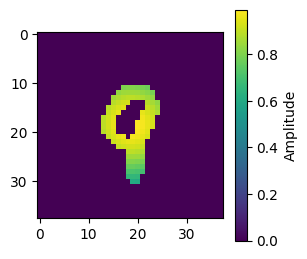

In [4]:
plt.figure(figsize=(3,3))
plt.imshow(np.squeeze(X_train_MNIST[0,0,:,:].detach().cpu().numpy()))
plt.colorbar(label='Amplitude')

In [5]:
ONN = Lin_ONN(SLM_size=120)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move input data to the device
X_train_MNIST = X_train_MNIST.to(device)

# Move model to the device
ONN.to(device)

# Measure forward pass time
torch.cuda.synchronize()
start_time = time.time()

# Forward pass
Y = ONN.forward(X_train_MNIST)

torch.cuda.synchronize()
end_time = time.time()

print(f'Forward pass time: {end_time - start_time} seconds')

Forward pass time: 0.3580794334411621 seconds


In [6]:
Y_cpu = np.squeeze(Y.detach().cpu().numpy())
X_cpu = np.squeeze(X_train_MNIST.detach().cpu().numpy())

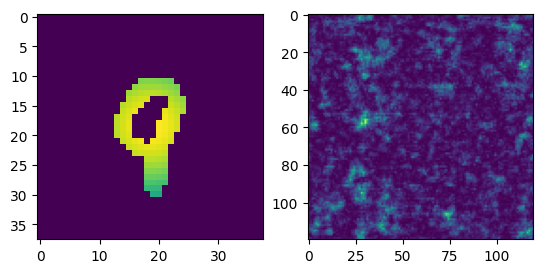

In [7]:
plt.subplot(1,2,1)
plt.imshow(np.squeeze(X_cpu[0,:,:]))
plt.subplot(1,2,2)
plt.imshow(np.squeeze(Y_cpu[0,:,:]))

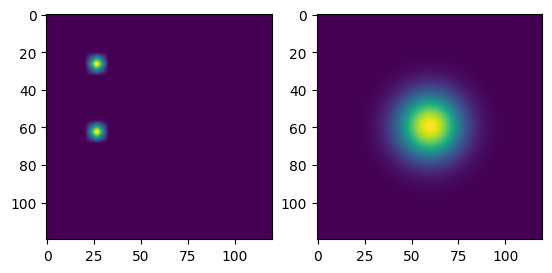

In [36]:
#generate a target image

image_t = torch.zeros((20,20))
image_t[4,4] = 1
image_t[10,4] = 1

image_t = image_t.unsqueeze(0).unsqueeze(0)
image_t = F.interpolate(image_t, size=(120, 120), mode='bilinear', align_corners=False)

Gaussian_beam = gaussian_beam(image_t.shape[-1])

plt.subplot(1,2,1)
plt.imshow(image_t.squeeze().detach().cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(Gaussian_beam.squeeze().detach().cpu().numpy())


In [37]:
#image_t = image_t.squeeze(0).reshape((1,image_t.shape[-1]*image_t.shape[-1]))
Gaussian_beam = Gaussian_beam.unsqueeze(0).unsqueeze(0)

BS_dataset = Custom_dataset(features=Gaussian_beam,labels=image_t)

train_loader_BS = torch.utils.data.DataLoader(dataset=BS_dataset, batch_size=1, shuffle=True)



In [38]:
ONN = Lin_ONN(SLM_size=120)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=ONN.parameters(), lr=0.1)

epochs = 1000
error_vec = []

ONN.to(device)
start_time = time.time()
for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(train_loader_BS):
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the gradients at the start of each iteration
        optimizer.zero_grad()
        
        # Forward pass
        pred = ONN(inputs)
        
        # Compute loss
        error = loss(pred, labels)
        
        # Backward pass to compute gradients
        error.backward()
        
        # Perform optimization step
        optimizer.step()
        
        # Append scalar value of error to error_vec
        error_vec.append(error.item())

end_time = time.time()
print(f'Training  time : {end_time - start_time}s')
    #print(f'{epoch + 1}/{epochs} : Current loss = {error.item()}')


Training  time : 1.7078664302825928s


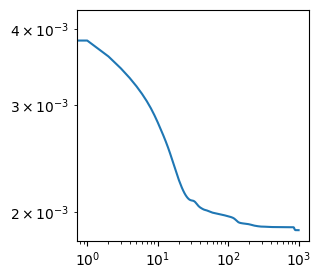

In [39]:
plt.figure(figsize=(3,3))
plt.loglog(error_vec)

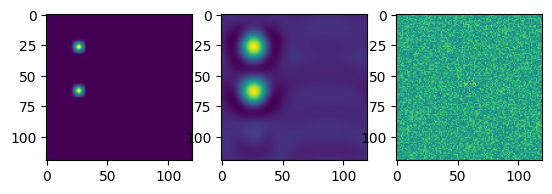

In [44]:
pred = ONN(inputs)

phase_mask = ONN.get_params().detach().cpu().reshape(ONN.SLM_size,ONN.SLM_size).numpy()

plt.subplot(1,3,1)
plt.imshow(labels.squeeze().squeeze().detach().cpu().numpy())
plt.subplot(1,3,2)
plt.imshow(pred.squeeze().squeeze().detach().cpu().numpy())
plt.subplot(1,3,3)
plt.imshow(phase_mask)
